Sergi Flores i Sam Brumwell

# Pràctica 4: Similitud de Text Semàntic (STS) per al Català

**Objectiu**: Aquest treball té com a objectiu principal desenvolupar, implementar i avaluar diferents arquitectures de models per a la tasca de similitud semàntica en català utilitzant el dataset STS-ca del projecte AINA, comparant varies tècniques i arquitectures per tal de veure les seves fortaleses i debilitats i seleccionar la més addient per aquesta tasca.


**Mètriques**: L'avaluació dels models es realitza mitjançant la **correlació de Pearson** com a mètrica principal, complementada amb l'error quadràtic mitjà (MSE) i l'error absolut mitjà (MAE). Aquesta aproximació permet mesurar tant la qualitat de l'ordenació de similituds com la precisió numèrica de les prediccions.

## Estructura de la Pràctica:
1. **Preparació d'Embeddings** - Carregar i truncar embeddings Word2Vec
2. **Models Baseline** - Similitud cosinus simple
3. **Model 1**: Embeddings Agregats - Vectors de frase concatenats
4. **Model 2**: Seqüència d'Embeddings - Amb mecanisme d'atenció
5. **Experimentació Avançada** - Comparació amb altres embeddings
6. **Conclusions i Observacions** - Comparativa global
7. **Entrenament amb dades TECLA** - Entrenar un model de classificació

In [1]:
# Imports necessaris
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional, Dict, Union
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.filterwarnings('ignore')
# Configuració de GPU (opcional)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: []


## 1. Carrega del Dataset STS-ca

Aquí carreguem el dataset "STS-ca" (Semantic Textual Similarity for Catalan) del projecte AINA, utilitzant la llibreria `datasets` de Hugging Face. Aquest dataset conté parells de frases en català i una etiqueta numèrica que indica el seu grau de similitud semàntica (normalment en una escala de 0 a 5).

El dataset es divideix en tres parts:
- `train`: conjunt d'entrenament, utilitzat per ajustar els paràmetres dels models.
- `test`: conjunt de prova, utilitzat per a l'avaluació final del model seleccionat.
- `validation`: conjunt de validació, utilitzat per monitorar el rendiment durant l'entrenament i per a l'ajust d'hiperparàmetres.

In [2]:
from datasets import load_dataset

# Carregar el dataset STS-ca
print("Carregant dataset STS-ca...")
train_data = load_dataset("projecte-aina/sts-ca", split="train")
test_data = load_dataset("projecte-aina/sts-ca", split="test") 
val_data = load_dataset("projecte-aina/sts-ca", split="validation")

# Convertir a DataFrame per facilitar la manipulació
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Label range: {train_df['label'].min():.2f} - {train_df['label'].max():.2f}")

# Mostrar alguns exemples
print("\nExemples del dataset:")
for i in range(3):
    print(f"Frase 1: {train_df.iloc[i]['sentence_1']}")
    print(f"Frase 2: {train_df.iloc[i]['sentence_2']}")
    print(f"Similitud: {train_df.iloc[i]['label']}")
    print("-" * 50)

Carregant dataset STS-ca...
Train samples: 2073
Test samples: 500
Validation samples: 500
Label range: 0.00 - 5.00

Exemples del dataset:
Frase 1: Atorga per primer cop les mencions Encarna Sanahuja a la inclusió de la perspectiva de gènere en docència Universitària
Frase 2: Creen la menció M. Encarna Sanahuja a la inclusió de la perspectiva de gènere en docència universitària
Similitud: 3.5
--------------------------------------------------
Frase 1: Finalment, afegiu-hi els bolets que haureu saltat en una paella amb oli i deixeu-ho coure tot junt durant 5 minuts.
Frase 2: Finalment, poseu-hi les minipastanagues tallades a dauets, els pèsols, rectifiqueu-ho de sal i deixeu-ho coure tot junt durant un parell de minuts més.
Similitud: 1.25
--------------------------------------------------
Frase 1: El TC suspèn el pla d'acció exterior i de relacions amb la UE de la Generalitat
Frase 2: El Constitucional manté la suspensió del pla estratègic d'acció exterior i relacions amb la UE
Similitu

## 2. Preparació d'Embeddings Word2Vec

En aquesta secció, carreguem embeddings de paraules pre-entrenats. Utilitzarem el model Word2Vec `cc.ca.300.vec`, que conté vectors de 300 dimensions per a paraules en català.

In [4]:
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess

# Carregar el model Word2Vec pre-entrenat
WV_MODEL_PATH = 'cc.ca.300.vec'

print("Carregant model Word2Vec...")

kv_model = KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)
print(f"Model carregat amb èxit. Vocabulari: {len(kv_model.key_to_index)} paraules")
print(f"Dimensió dels vectors: {kv_model.vector_size}")

Carregant model Word2Vec...


KeyboardInterrupt: 

A continuació mostrem alguns exemples dels embeddings generats.

In [ ]:
# Exemple d'ús
test_words = ["casa", "gat", "aigua", "carbassot"]
for word in test_words:
    if word in kv_model:
        print(f"Vector per '{word}': {kv_model[word][:5]}... (dim={kv_model.vector_size})")
    else:
        print(f"Paraula '{word}' no trobada al vocabulari")

Vector per 'casa': [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (dim=300)
Vector per 'gat': [ 0.0061  0.0675 -0.0248 -0.0541 -0.0722]... (dim=300)
Vector per 'aigua': [-0.0031  0.0427 -0.0397  0.0366 -0.0551]... (dim=300)
Vector per 'carbassot': [-0.0029 -0.0462 -0.0255 -0.0149 -0.0358]... (dim=300)



#### Truncament d'Embeddings

Es defineix la funció `create_truncated_embeddings` per generar versions dels embeddings amb dimensions més petites (50, 100, 150). Això permetrà experimentar com la dimensionalitat dels embeddings afecta el rendiment dels models. El truncament es fa simplement seleccionant les primeres `N` dimensions del vector original.

In [ ]:
# Funció per truncar embeddings a dimensions més petites
def create_truncated_embeddings(kv_model, dimensions: List[int]) -> Dict[int, Dict[str, np.ndarray]]:
    """
    Crea versions truncades dels embeddings amb diferents dimensions
    """
    if kv_model is None:
        return {}
    
    truncated_models = {}
    
    for dim in dimensions:
        print(f"Creant embeddings de {dim} dimensions...")
        truncated_dict = {}
        
        for word in kv_model.key_to_index:
            original_vector = kv_model[word]
            truncated_vector = original_vector[:dim]
            truncated_dict[word] = truncated_vector
            
        truncated_models[dim] = truncated_dict
        print(f"  Completat: {len(truncated_dict)} paraules truncades a {dim}D")
    
    return truncated_models

# Crear versions truncades
dimensions = [50, 100, 150, 300]  # Incloem 300 per consistència
if kv_model is not None:
    truncated_embeddings = create_truncated_embeddings(kv_model, dimensions)
    print(f"\nVersions d'embeddings disponibles: {list(truncated_embeddings.keys())}")
else:
    truncated_embeddings = {}


Creant embeddings de 50 dimensions...
  Completat: 2000000 paraules truncades a 50D
Creant embeddings de 100 dimensions...
  Completat: 2000000 paraules truncades a 100D
Creant embeddings de 150 dimensions...
  Completat: 2000000 paraules truncades a 150D
Creant embeddings de 300 dimensions...
  Completat: 2000000 paraules truncades a 300D

Versions d'embeddings disponibles: [50, 100, 150, 300]


Visualitzem algun exemple dels embeddings truncats.

In [ ]:
print("Model truncat a 50 dimensions:")
print(truncated_embeddings[50]['casa'])
print("Model truncat a 100 dimensions:")
print(truncated_embeddings[100]['casa'])

Model truncat a 50 dimensions:
[-0.0359 -0.0161 -0.0268  0.0022 -0.0873  0.003   0.0992 -0.0075  0.068
 -0.029   0.0186  0.1191  0.0155  0.0375  0.0158  0.0449 -0.1111  0.0606
  0.022   0.0341  0.0304 -0.0182 -0.024   0.1791 -0.0036  0.0754 -0.1102
  0.0247  0.0228  0.028   0.0685 -0.0146 -0.087  -0.0444  0.0057  0.0172
  0.0022  0.1482  0.029  -0.0377  0.0114 -0.044  -0.0019 -0.0501  0.002
 -0.1389 -0.0044  0.0512 -0.0065  0.0007]
Model truncat a 100 dimensions:
[-0.0359 -0.0161 -0.0268  0.0022 -0.0873  0.003   0.0992 -0.0075  0.068
 -0.029   0.0186  0.1191  0.0155  0.0375  0.0158  0.0449 -0.1111  0.0606
  0.022   0.0341  0.0304 -0.0182 -0.024   0.1791 -0.0036  0.0754 -0.1102
  0.0247  0.0228  0.028   0.0685 -0.0146 -0.087  -0.0444  0.0057  0.0172
  0.0022  0.1482  0.029  -0.0377  0.0114 -0.044  -0.0019 -0.0501  0.002
 -0.1389 -0.0044  0.0512 -0.0065  0.0007  0.0245  0.0052  0.0003  0.0288
  0.0476  0.0015  0.1529 -0.0132  0.025  -0.0274  0.0314  0.0709 -0.0816
 -0.0661  0.0462  0.007

## 3. Funcions d'Utilitat per Processament de Text

Aquesta secció defineix funcions auxiliars clau per al processament de text i la generació d'embeddings de frases, que seran utilitzades pels diferents models.

**Funcions Definides:**

1.  `preprocess_sentence`:
    *   **Objectiu**: Tokenitza la frase.
    *   **Funcionament**: Converteix a minúscules i divideix en paraules amb `simple_preprocess`.

2.  `get_sentence_embedding_simple`:
    *   **Objectiu**: Crea un embedding de frase mitjançant la mitjana dels embeddings de paraules.
    *   **Funcionament**: Preprocessa la frase, obté els vectors de paraules existents del diccionari d'embeddings i en calcula la mitjana. Retorna zeros si no hi ha embeddings.

3.  `get_sentence_embedding_tfidf`:
    *   **Objectiu**: Crea un embedding de frase amb una mitjana ponderada per TF-IDF dels embeddings de paraules.
    *   **Funcionament**: Preprocessa la frase, calcula pesos TF-IDF, i fa una mitjana ponderada dels embeddings de paraules. Retorna zeros si no es poden obtenir vectors ponderats.

**Preparació del Vocabulari per TF-IDF:**
*   Es recullen totes les frases dels conjunts d'entrenament, validació i prova.
*   Es preprocessen per extreure totes les paraules i construir un vocabulari global. Aquest vocabulari serà utilitzat per entrenar el `TfidfVectorizer` més endavant.

In [ ]:
def preprocess_sentence(sentence: str) -> List[str]:
    """
    Preprocessa una frase: tokenització simple
    """
    return simple_preprocess(sentence.lower())

def get_sentence_embedding_simple(sentence: str, embeddings_dict: Dict[str, np.ndarray], 
                                vector_size: int) -> np.ndarray:
    """
    Obté l'embedding d'una frase fent la mitjana dels embeddings de les paraules
    """
    words = preprocess_sentence(sentence)
    vectors = []
    
    for word in words:
        if word in embeddings_dict:
            vectors.append(embeddings_dict[word])
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

def get_sentence_embedding_tfidf(sentence: str, embeddings_dict: Dict[str, np.ndarray], 
                               tfidf_vectorizer: TfidfVectorizer, 
                               feature_names: List[str], vector_size: int) -> np.ndarray:
    """
    Obté l'embedding d'una frase fent la mitjana ponderada amb TF-IDF
    """
    words = preprocess_sentence(sentence)
    
    # Calcular TF-IDF per a la frase
    tfidf_vector = tfidf_vectorizer.transform([' '.join(words)])
    tfidf_scores = tfidf_vector.toarray()[0]
    
    weighted_vectors = []
    weights = []
    
    for word in words:
        if word in embeddings_dict and word in feature_names:
            word_idx = feature_names.index(word)
            weight = tfidf_scores[word_idx]
            if weight > 0:
                weighted_vectors.append(embeddings_dict[word] * weight)
                weights.append(weight)
    
    if weighted_vectors and sum(weights) > 0:
        return np.sum(weighted_vectors, axis=0) / sum(weights)
    else:
        return np.zeros(vector_size)

# Preprocessar totes les frases del dataset
print("Preprocessant frases del dataset...")
all_sentences = (train_df['sentence_1'].tolist() + train_df['sentence_2'].tolist() + 
                test_df['sentence_1'].tolist() + test_df['sentence_2'].tolist() + 
                val_df['sentence_1'].tolist() + val_df['sentence_2'].tolist())

# Crear vocabulari per TF-IDF
all_words = []
for sentence in all_sentences:
    all_words.extend(preprocess_sentence(sentence))

print(f"Total de frases processades: {len(all_sentences)}")
print(f"Vocabulari únic: {len(set(all_words))} paraules")

Preprocessant frases del dataset...
Total de frases processades: 6146
Vocabulari únic: 13125 paraules


## 4. Baseline: Similitud Cosinus

Aquesta secció implementa un model baseline simple per establir un punt de referència per a la tasca de STS. L'enfocament consisteix a calcular la similitud cosinus directa entre els embeddings de frases, obtinguts mitjançant la mitjana dels embeddings de paraules Word2Vec.

**Objectiu i Metodologia:**

El baseline serveix per establir una línia base de rendiment que els models més complexos hauran de superar. S'utilitza la similitud cosinus perquè és una mètrica estàndard per mesurar la similitud semàntica entre vectors d'embedding. Es proven dues variants: mitjana simple dels embeddings de paraules i mitjana ponderada per TF-IDF, aquesta última per donar més pes a paraules més discriminatives.

Les similituds cosinus (rang `[-1,1]`) s'escalen a `[0,5]` per coincidir amb les etiquetes del dataset STS-ca. S'avaluen múltiples dimensions d'embedding (50D, 100D, 150D, 300D) per analitzar l'impacte de la dimensionalitat.

La mètrica principal d'avaluació és la correlació de Pearson, que mesura com de bé les prediccions del model es correlacionen amb les puntuacions de similitud humanes.

In [ ]:
def evaluate_cosine_baseline(df: pd.DataFrame, embeddings_dict: Dict[str, np.ndarray], 
                           vector_size: int, use_tfidf: bool = False, 
                           tfidf_vectorizer=None, feature_names=None) -> Dict[str, float]:
    """
    Avalua el baseline de similitud cosinus
    """
    similarities = []
    true_scores = df['label'].values
    
    for _, row in df.iterrows():
        sent1, sent2 = row['sentence_1'], row['sentence_2']
        
        if use_tfidf and tfidf_vectorizer is not None:
            vec1 = get_sentence_embedding_tfidf(sent1, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
            vec2 = get_sentence_embedding_tfidf(sent2, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
        else:
            vec1 = get_sentence_embedding_simple(sent1, embeddings_dict, vector_size)
            vec2 = get_sentence_embedding_simple(sent2, embeddings_dict, vector_size)
        
        # Calcular similitud cosinus
        if np.all(vec1 == 0) or np.all(vec2 == 0):
            sim = 0.0
        else:
            sim = 1 - cosine(vec1, vec2)
        
        # Escalar de [-1,1] a [0,5] per coincidir amb les etiquetes
        sim_scaled = (sim + 1) * 2.5
        similarities.append(sim_scaled)
    
    # Calcular mètriques
    similarities = np.array(similarities)
    pearson_corr, _ = pearsonr(true_scores, similarities)
    mse = mean_squared_error(true_scores, similarities)
    mae = mean_absolute_error(true_scores, similarities)
    
    return {
        'pearson': pearson_corr,
        'mse': mse,
        'mae': mae,
        'predictions': similarities
    }

# Preparar TF-IDF
if kv_model is not None:
    print("Preparant TF-IDF vectorizer...")
    corpus_for_tfidf = [' '.join(preprocess_sentence(sent)) for sent in all_sentences]
    tfidf_vectorizer = TfidfVectorizer(max_features=10000, lowercase=True)
    tfidf_vectorizer.fit(corpus_for_tfidf)
    feature_names = tfidf_vectorizer.get_feature_names_out().tolist()
    
    print("Avaluant baselines de similitud cosinus...")
    
    # Avaluar per diferents dimensions
    baseline_results = {}
    results_list = []
    for dim in [50, 100, 150, 300]:
        if dim in truncated_embeddings:
            # Mitjana simple
            results_simple = evaluate_cosine_baseline(
                val_df, truncated_embeddings[dim], dim, use_tfidf=False
            )

            # Mitjana ponderada TF-IDF
            results_tfidf = evaluate_cosine_baseline(
                val_df, truncated_embeddings[dim], dim, use_tfidf=True,
                tfidf_vectorizer=tfidf_vectorizer, feature_names=feature_names
            )

            baseline_results[dim] = {
                'simple': results_simple,
                'tfidf': results_tfidf
            }

            results_list.append({
                'Model': 'Baseline Cosinus Simple',
                'Dimensions': f'{dim}D',
                'Pearson': results_simple['pearson'],
                'MSE': results_simple['mse'],
                'MAE': results_simple['mae']
            })
            results_list.append({
                'Model': 'Baseline Cosinus TF-IDF',
                'Dimensions': f'{dim}D',
                'Pearson': results_tfidf['pearson'],
                'MSE': results_tfidf['mse'],
                'MAE': results_tfidf['mae']
            })

Preparant TF-IDF vectorizer...
Avaluant baselines de similitud cosinus...


In [ ]:
print("\n=== COMPARACIÓ MODELS BASELINE COSINUS ===")
df_baseline_results = pd.DataFrame(results_list)
display(df_baseline_results.style.hide(axis="index"))


=== COMPARACIÓ MODELS BASELINE COSINUS ===


Model,Dimensions,Pearson,MSE,MAE
Baseline Cosinus Simple,50D,0.175156,6.156660,2.335413
Baseline Cosinus TF-IDF,50D,0.288679,5.862487,2.279328
Baseline Cosinus Simple,100D,0.213043,5.936303,2.290625
Baseline Cosinus TF-IDF,100D,0.322226,5.572608,2.219603
Baseline Cosinus Simple,150D,0.241811,5.704033,2.242433
Baseline Cosinus TF-IDF,150D,0.356393,5.332225,2.169574
Baseline Cosinus Simple,300D,0.243586,5.424708,2.181605
Baseline Cosinus TF-IDF,300D,0.354348,5.084731,2.115081


### Anàlisi dels Resultats Baseline

L'avaluació dels models baseline mostra patrons clars sobre l'impacte de la dimensionalitat i les tècniques de ponderació en la similitud semàntica. Els resultats revelen una millora consistent amb l'augment de dimensions: el model simple passa de 0.175 a 0.244 Pearson (39% de millora) entre 50D i 300D, amb els guanys més significatius concentrats fins a 150D.

La ponderació TF-IDF supera sistemàticament la mitjana simple, proporcionant millores del 65% en dimensions baixes i del 47% aproximadament en dimensions mitjanes. Aquesta superioritat consistent demostra la importància de ponderar adequadament les paraules discriminatives per capturar millor la similitud semàntica.

La configuració òptima es troba en TF-IDF amb 150D (Pearson: 0.356), oferint el millor equilibri rendiment-eficiència, ja que l'augment a 300D només aporta millores marginals. Tots els models mostren valors MSE consistents al voltant de 5-6, indicant prediccions dins d'un rang raonable.

Aquest baseline estableix un **llindar de referència de 0.356 Pearson** que els models més sofisticats hauran de superar per demostrar millores significatives.

## 5. Model 1: Regressió amb Embeddings Agregats

Aquest primer model neuronal representa un salt qualitatiu respecte als baselines, implementant una arquitectura de xarxa neuronal densa per aprendre relacions complexes entre parells de frases.

### Arquitectura i Metodologia

L'aproximació dels embeddings agregats es basa en convertir cada frase a un vector de longitud fixa mitjançant la mitjana dels embeddings de les seves paraules. Aquests vectors s'alimenten a una xarxa neuronal que aprèn a predir la similitud semàntica directament des de la representació vectorial de les frases.

L'arquitectura del model segueix un disseny jeràrquic amb múltiples capes denses. Primer, els dos vectors de frase es concatenen per formar un vector d'entrada de dimensió `2 × embedding_dim`. Aquest vector passa per capes de normalització per lotes, seguides de capes denses amb activació ReLU i regularització mitjançant dropout. La sortida final és una predicció numèrica de similitud obtinguda amb una capa densa lineal.

### Implementació i Entrenament

El model incorpora diverses tècniques de regularització per evitar l'overfitting: batch normalization per estabilitzar l'entrenament, dropout amb taxes variables segons la profunditat de la capa, i early stopping basat en la loss de validació. L'optimitzador Adam amb learning rate adaptatiu permet una convergència eficient.

Durant l'entrenament, es proven diferents dimensions d'embedding (50D, 100D, 150D, 300D).

In [ ]:
def build_model_aggregated(embedding_dim: int, hidden_size: int = 256, 
                          dropout_rate: float = 0.3) -> tf.keras.Model:
    """
    Model amb millor arquitectura
    """
    input_1 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_1")
    input_2 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_2")
    
    # Normalitzar inputs (L2 normalization)
    norm_1 = tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(input_1)
    norm_2 = tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(input_2)
    
    # Múltiples formes de combinar els vectors
    concatenated = tf.keras.layers.Concatenate(axis=-1)([norm_1, norm_2])
    
    # Diferència absoluta (captura dissimilitud)
    abs_diff = tf.keras.layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([norm_1, norm_2])
    
    # Producte element-wise (captura similitud)
    element_wise = tf.keras.layers.Multiply()([norm_1, norm_2])
    
    # Combinar totes les representacions
    combined = tf.keras.layers.Concatenate(axis=-1)([concatenated, abs_diff, element_wise])
    
    # Arquitectura més robusta
    x = tf.keras.layers.BatchNormalization()(combined)
    x = tf.keras.layers.Dense(hidden_size, activation='relu', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.Dense(hidden_size // 2, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.Dense(hidden_size // 4, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate / 2)(x)
    
    # Capa de sortida amb activació sigmoid escalada a [0,5]
    output_raw = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    output = tf.keras.layers.Lambda(lambda x: x * 5.0)(output_raw)  # Escalar a [0,5]
    
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    
    # Utilitzar Huber loss (més robust a outliers)
    model.compile(
        loss=tf.keras.losses.Huber(delta=1.0),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model

def prepare_aggregated_data(df: pd.DataFrame, embeddings_dict: Dict[str, np.ndarray], 
                           vector_size: int, use_tfidf: bool = False,
                           tfidf_vectorizer=None, feature_names=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    X1, X2, Y = [], [], []
    invalid_count = 0
    
    for _, row in df.iterrows():
        sent1, sent2, label = row['sentence_1'], row['sentence_2'], row['label']
        
        if use_tfidf and tfidf_vectorizer is not None:
            vec1 = get_sentence_embedding_tfidf(sent1, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
            vec2 = get_sentence_embedding_tfidf(sent2, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
        else:
            vec1 = get_sentence_embedding_simple(sent1, embeddings_dict, vector_size)
            vec2 = get_sentence_embedding_simple(sent2, embeddings_dict, vector_size)
        
        # Validar embeddings
        if np.any(np.isnan(vec1)) or np.any(np.isnan(vec2)):
            invalid_count += 1
            continue
            
        X1.append(vec1)
        X2.append(vec2)
        Y.append(label)
    
    if invalid_count > 0:
        print(f"Warning: {invalid_count} mostres amb embeddings invàlids eliminades")
    
    return np.array(X1), np.array(X2), np.array(Y)

# Codi d'entrenament
if kv_model is not None:
    aggregated_results = {}
    
    for dim in [50, 100, 150, 300]:
        if dim in truncated_embeddings:
            print(f"\n=== Entrenant Model Agregat {dim}D ===")
            
            # Preparar dades
            X1_train, X2_train, Y_train = prepare_aggregated_data(
                train_df, truncated_embeddings[dim], dim
            )
            X1_val, X2_val, Y_val = prepare_aggregated_data(
                val_df, truncated_embeddings[dim], dim
            )
            
            print(f"Forma de les dades: X1_train={X1_train.shape}, Y_train={Y_train.shape}")
            print(f"Rang Y_train: [{Y_train.min():.2f}, {Y_train.max():.2f}]")
            
            # Construir model
            model = build_model_aggregated(embedding_dim=dim, hidden_size=256)
            
            # Callbacks
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=15, restore_best_weights=True, 
                verbose=1, min_delta=0.001
            )
            
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.3, patience=7, min_lr=1e-7, verbose=1
            )
            
            # Learning rate scheduler
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: 0.001 * (0.9 ** epoch)
            )
            
            # Entrenament
            history = model.fit(
                [X1_train, X2_train], Y_train,
                validation_data=([X1_val, X2_val], Y_val),
                epochs=100,  # Més èpoques
                batch_size=64,  # Batch size més gran
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
            
            # Avaluació
            Y_pred = model.predict([X1_val, X2_val]).flatten()
            
            # Clips predictions to valid range
            Y_pred = np.clip(Y_pred, 0, 5)
            
            pearson_corr, _ = pearsonr(Y_val, Y_pred)
            mse = mean_squared_error(Y_val, Y_pred)
            mae = mean_absolute_error(Y_val, Y_pred)
            
            aggregated_results[dim] = {
                'model': model,
                'history': history,
                'pearson': pearson_corr,
                'mse': mse,
                'mae': mae,
                'predictions': Y_pred
            }
            
            print(f"Resultats {dim}D - Pearson: {pearson_corr:.3f}, MSE: {mse:.3f}, MAE: {mae:.3f}")
            
            # Diagnosis adicional
            print(f"Prediccions - Min: {Y_pred.min():.3f}, Max: {Y_pred.max():.3f}, Mean: {Y_pred.mean():.3f}")
            print(f"Targets - Min: {Y_val.min():.3f}, Max: {Y_val.max():.3f}, Mean: {Y_val.mean():.3f}")


=== Entrenant Model Agregat 50D ===
Forma de les dades: X1_train=(2073, 50), Y_train=(2073,)
Rang Y_train: [0.00, 5.00]
Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1194 - mae: 1.1343 - root_mean_squared_error: 1.3985 - val_loss: 0.7032 - val_mae: 0.6608 - val_root_mean_squared_error: 0.8524 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9279 - mae: 0.9318 - root_mean_squared_error: 1.1611 - val_loss: 0.6962 - val_mae: 0.6590 - val_root_mean_squared_error: 0.8507 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8378 - mae: 0.8369 - root_mean_squared_error: 1.0403 - val_loss: 0.6939 - val_mae: 0.6751 - val_root_mean_squared_error: 0.8608 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8146 - mae: 0.8139 - root_mean_squared_error: 1.0249 - val_loss: 0.6959 - val_mae: 0.6888 - val_root_mean_squared_error: 0.8764 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━

A continuació fem una comparativa dels models agregats.

In [ ]:
print("\n=== COMPARACIÓ MODELS AGREGATS ===")
# Crear un DataFrame amb els resultats dels models agregats
aggr_data = []
for dim in [50, 100, 150, 300]:
    if dim in aggregated_results:
        aggr_data.append({
            'Model': 'Model Agregat',
            'Dimensions': f'{dim}D',
            'Pearson': aggregated_results[dim]['pearson'],
            'MSE': aggregated_results[dim]['mse'],
            'MAE': aggregated_results[dim]['mae']
        })

df_aggregated = pd.DataFrame(aggr_data)
df_results = pd.concat([df_baseline_results, df_aggregated], ignore_index=True)
display(df_aggregated.style.hide(axis="index"))


=== COMPARACIÓ MODELS AGREGATS ===


Model,Dimensions,Pearson,MSE,MAE
Model Agregat,50D,0.388917,0.651528,0.602588
Model Agregat,100D,0.418242,0.617774,0.591511
Model Agregat,150D,0.411732,0.634592,0.612983
Model Agregat,300D,0.440120,0.613584,0.595229


### Anàlisi dels Models Agregats

Els models agregats mostren una millora significativa respecte als resultats anteriors, amb correlacions de Pearson que oscil·len entre 0.39 i 0.44, superant clarament el llindar de referència establert pels baselines (0.356). El millor resultat s'obté amb 300D (Pearson: 0.440), seguint un patró de millora gradual amb l'augment de dimensions fins als 100D, després es manté relativament estable.

Els errors MSE es mantenen consistents al voltant de 0.61-0.65, mentre que els MAE oscil·len entre 0.59-0.61, indicant prediccions més precises que les versions anteriors. La millora més notable es produeix entre 50D i 100D (increment del 7.5% en Pearson), mentre que l'augment posterior és més moderat.

Aquests resultats demostren que les millores implementades en l'arquitectura del model (normalització L2, múltiples formes de combinació de vectors, regularització Huber loss) han tingut un impacte positiu substancial, convertint els models agregats en una alternativa viable que supera els baselines tradicionals.

## 6. Model 2: Seqüència d'Embeddings amb Atenció

Aquest segon model neuronal representa una aproximació més sofisticada que processa les frases com a seqüències d'embeddings de paraules, incorporant un mecanisme d'atenció per capturar millor les dependències entre paraules i la importància relativa de cada terme en el context de la similitud semàntica.

### Arquitectura i Metodologia

L'enfocament de seqüències d'embeddings manté l'ordre i la informació posicional de les paraules dins de cada frase, contrastant amb l'agregació simple del Model 1. L'arquitectura utilitza una capa d'embedding compartida que mapeja els índexs de paraules a vectors densos, seguida d'un mecanisme d'atenció que aprèn a ponderar automàticament la importància de cada paraula per a la tasca de similitud.

La **capa d'atenció simple** implementada calcula pesos d'atenció mitjançant una xarxa neuronal de dues capes: primer transforma els embeddings d'entrada amb una capa densa amb activació `tanh`, després computa puntuacions d'atenció amb una segona capa densa. Els pesos resultants s'apliquen per generar un vector de context que representa tota la seqüència.

El model calcula la **similitud cosinus** entre els vectors de context normalitzats de les dues frases, escalant el resultat de `[-1,1]` a `[0,1]` per coincidir amb les etiquetes del dataset. Aquest enfocament és més principiat que la regressió directa, ja que explota la naturalesa geomètrica de la similitud semàntica.

### Experimentació amb Embeddings Entrenables

Seguint els requeriments de la pràctica, s'implementen tres configuracions d'embeddings per analitzar l'impacte del fine-tuning:

1. **Embeddings Pre-entrenats Frozen**: Els pesos de Word2Vec es mantenen fixos durant l'entrenament, preservant el coneixement semàntic original.

2. **Embeddings Pre-entrenats Trainable**: Els embeddings s'inicialitzen amb Word2Vec però s'actualitzen durant l'entrenament, permetent l'adaptació a la tasca específica.

3. **Embeddings Aleatoris**: Inicialització aleatòria dels embeddings, entrenant-los completament des de zero.

Durant l'entrenament, es proven aquestes configuracions en diferents dimensions d'embedding (50D, 100D, 150D, 300D) per analitzar com la dimensionalitat interactua amb el fine-tuning dels embeddings.

In [ ]:
import tensorflow as tf
import numpy as np
from typing import Optional

class SimpleAttention(tf.keras.layers.Layer):
    """
    Capa d'atenció simple per agregar seqüències d'embeddings
    """
    def __init__(self, units: int, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.units = units
        self.dropout_s1 = tf.keras.layers.Dropout(0.3)
        self.dropout_s2 = tf.keras.layers.Dropout(0.2)
        self.W_s1 = tf.keras.layers.Dense(units, activation='tanh', use_bias=True, name="attention_transform")
        # Capa densa per calcular puntuacions d'atenció (vector de context)
        self.W_s2 = tf.keras.layers.Dense(1, use_bias=False, name="attention_scorer")
        self.supports_masking = True  # Declara que aquesta capa suporta masking

    def call(self, inputs: tf.Tensor, mask: Optional[tf.Tensor] = None) -> tf.Tensor:
        # forma dels inputs: (batch_size, sequence_length, embedding_dim)
        # forma de la màscara: (batch_size, sequence_length) tensor booleà

        # Estats ocults d'atenció
        hidden_states = self.dropout_s1(self.W_s1(inputs))

        # Calcular puntuacions d'atenció
        scores = self.dropout_s2(self.W_s2(hidden_states))

        if mask is not None:
            # Aplicar la màscara a les puntuacions abans del softmax
            expanded_mask = tf.expand_dims(tf.cast(mask, dtype=tf.float32), axis=-1)
            # Afegir un número negatiu gran a les puntuacions emmascerades (padding)
            scores += (1.0 - expanded_mask) * -1e9

        # Calcular pesos d'atenció
        attention_weights = tf.nn.softmax(scores, axis=1)

        # Calcular el vector de context (suma ponderada dels embeddings d'entrada)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        return context_vector

    def get_config(self) -> dict:
        config = super(SimpleAttention, self).get_config()
        config.update({"units": self.units})
        return config

    def compute_mask(self, inputs: tf.Tensor, mask: Optional[tf.Tensor] = None) -> Optional[tf.Tensor]:
        return None


def build_model_sequence(vocab_size: int = 1000, 
                        embedding_dim: int = 300,
                        sequence_length: int = 32,
                        learning_rate: float = 0.001,
                        trainable_embeddings: bool = False,
                        pretrained_weights: Optional[np.ndarray] = None,
                        use_attention: bool = True,
                        attention_units: int = 4) -> tf.keras.Model:
    """
    Model de seqüència millorat basat en build_and_compile_model_2
    Incorpora similitud cosinus i escalat adequat per STS
    """
    input_1 = tf.keras.Input((sequence_length,), dtype=tf.int32, name="input_1")
    input_2 = tf.keras.Input((sequence_length,), dtype=tf.int32, name="input_2")

    # Determinar paràmetres efectius d'embedding
    if pretrained_weights is not None:
        effective_dictionary_size = pretrained_weights.shape[0]
        effective_embedding_size = pretrained_weights.shape[1]
        embedding_initializer = tf.keras.initializers.Constant(pretrained_weights)
        is_embedding_trainable = trainable_embeddings
        embedding_layer_name = "embedding_pretrained"
    else:
        effective_dictionary_size = vocab_size
        effective_embedding_size = embedding_dim
        embedding_initializer = 'uniform'
        is_embedding_trainable = True
        embedding_layer_name = "embedding"

    # Capa d'Embedding Compartida
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=effective_dictionary_size,
        output_dim=effective_embedding_size,
        input_length=sequence_length,
        mask_zero=True,
        embeddings_initializer=embedding_initializer,
        trainable=is_embedding_trainable,
        name=embedding_layer_name
    )

    # Aplicar la capa d'embedding a ambdues entrades
    embedded_1 = embedding_layer(input_1)  # Forma: (batch_size, sequence_length, effective_embedding_size)
    embedded_2 = embedding_layer(input_2)  # Forma: (batch_size, sequence_length, effective_embedding_size)

    # Capa compartida de pooling/atenció
    if use_attention:
        # Utilitzar mecanisme d'atenció
        sentence_pooling_layer = SimpleAttention(units=attention_units, name="sentence_attention")
    else:
        # Utilitzar pooling mitjà global simple
        sentence_pooling_layer = tf.keras.layers.GlobalAveragePooling1D(name="sentence_attention_layer")

    # Aplicar pooling/atenció per obtenir vectors de frase
    sentence_vector_1 = sentence_pooling_layer(embedded_1)
    sentence_vector_2 = sentence_pooling_layer(embedded_2)

    # Capa de projecció
    first_projection_layer = tf.keras.layers.Dense(
        effective_embedding_size,
        activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
        name="projection_layer"
    )
    dropout = tf.keras.layers.Dropout(0.2, name="projection_dropout")
    projected_1 = dropout(first_projection_layer(sentence_vector_1))
    projected_2 = dropout(first_projection_layer(sentence_vector_2))

    # Normalitzar els vectors projectats (normalització L2)
    normalized_1 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_1"
    )(projected_1)
    normalized_2 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_2"
    )(projected_2)

    # Calcular Similitud Cosinus
    similarity_score = tf.keras.layers.Lambda(
        lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True), name="cosine_similarity"
    )([normalized_1, normalized_2])

    # Escalar similitud
    output_layer = tf.keras.layers.Lambda(
        lambda x: 0.5 * (1.0 + x), name="output_scaling"
    )(similarity_score)

    # Definir el Model de Keras
    model = tf.keras.Model(
        inputs=[input_1, input_2],
        outputs=output_layer,
        name="sequence_similarity_attention_model"
    )

    # Compilar el model
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae'],
    )

    return model


Aquestes són les funcions que es defineixen i seràn utilitzades posteriorment:

*   `create_vocabulary_mapping`: Crea un diccionari que assigna a cada paraula un índex únic i viceversa. Això és essencial per convertir text en dades numèriques que els models poden processar.

*   `sentence_to_sequence`: Transforma una frase en una seqüència d'índexs utilitzant el diccionari creat anteriorment. Aquesta funció també s'encarrega de fer padding o truncament per assegurar que totes les seqüències tinguin la mateixa longitud.

*   `create_pretrained_embedding_matrix`: Crea una matriu d'embeddings pre-entrenats on cada fila correspon a l'embedding d'una paraula del vocabulari. Si una paraula no es troba en els embeddings pre-entrenats, el seu vector es manté a zero.

In [ ]:
from typing import List, Dict, Tuple
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# Preparació de dades per al model de seqüències
def create_vocabulary_mapping(sentences: List[str], max_vocab_size: int = 10000) -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Crea un mapatge de vocabulari paraula->índex i índex->paraula
    """
    word_counts = {}
    for sentence in sentences:
        words = preprocess_sentence(sentence)
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1
    
    # Ordenar per freqüència i prendre les més comunes
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Reservar índexs especials: 0=PAD, 1=UNK
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}
    idx_to_word = {0: "<PAD>", 1: "<UNK>"}
    
    for word, count in sorted_words[:max_vocab_size-2]:  # -2 per PAD i UNK
        idx = len(word_to_idx)
        word_to_idx[word] = idx
        idx_to_word[idx] = word
    
    return word_to_idx, idx_to_word

def sentence_to_sequence(sentence: str, word_to_idx: Dict[str, int], 
                        max_length: int = 32) -> np.ndarray:
    """
    Converteix una frase a seqüència d'índexs
    """
    words = preprocess_sentence(sentence)
    sequence = []
    
    for word in words:
        if word in word_to_idx:
            sequence.append(word_to_idx[word])
        else:
            sequence.append(word_to_idx["<UNK>"])
    
    # Padding o truncament
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        sequence.extend([word_to_idx["<PAD>"]] * (max_length - len(sequence)))
    
    return np.array(sequence)

def create_pretrained_embedding_matrix(word_to_idx: Dict[str, int], 
                                     embeddings_dict: Dict[str, np.ndarray],
                                     embedding_dim: int) -> np.ndarray:
    """
    Crea una matriu d'embeddings pre-entrenats
    """
    vocab_size = len(word_to_idx)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, idx in word_to_idx.items():
        if word in embeddings_dict:
            embedding_matrix[idx] = embeddings_dict[word]
        # Les paraules no trobades mantenen vectors zero
    
    return embedding_matrix


### Execució dels Models de Seqüència

Aquesta secció obté els resultats obtinguts pels models de seqüència, que processen les frases com a seqüències d'embeddings de paraules i utilitzen un mecanisme d'atenció per capturar les dependències entre les paraules. S'han entrenat tres variants d'aquests models mencionades anteriorment, diferenciant-se en com s'han gestionat els embeddings:

L'objectiu és comparar el rendiment d'aquestes variants i determinar quin enfocament proporciona els millors resultats en la tasca de similitud semàntica.


In [ ]:
print("Preparant dades per al model de seqüències...")

# Crear vocabulari
word_to_idx, idx_to_word = create_vocabulary_mapping(all_sentences, max_vocab_size=10000)
vocab_size = len(word_to_idx)
sequence_length = 32

print(f"Vocabulari creat: {vocab_size} paraules")
print(f"Longitud de seqüència: {sequence_length}")

# Convertir dades per a models de seqüència
def prepare_sequence_data(df):
    X1_seq, X2_seq, Y_seq = [], [], []
    for _, row in df.iterrows():
        seq1 = sentence_to_sequence(row['sentence_1'], word_to_idx, sequence_length)
        seq2 = sentence_to_sequence(row['sentence_2'], word_to_idx, sequence_length)
        X1_seq.append(seq1)
        X2_seq.append(seq2)
        Y_seq.append(row['label'])
    return np.array(X1_seq), np.array(X2_seq), np.array(Y_seq)

X1_train_seq, X2_train_seq, Y_train_seq = prepare_sequence_data(train_df)
X1_val_seq, X2_val_seq, Y_val_seq = prepare_sequence_data(val_df)

print(f"Dades de seqüència preparades: {X1_train_seq.shape}")

# Entrenar models de seqüència per diferents dimensions
sequence_results = {}

for embedding_dim in [50, 100, 150, 300]:
    if embedding_dim in truncated_embeddings:
        print(f"\n=== MODELS DE SEQÜÈNCIA {embedding_dim}D ===")
        
        # Preparar matriu d'embeddings pre-entrenats
        pretrained_matrix = create_pretrained_embedding_matrix(
            word_to_idx, truncated_embeddings[embedding_dim], embedding_dim
        )
        
        # Model 1: Embeddings pre-entrenats (frozen)
        print(f"Entrenant model amb embeddings pre-entrenats frozen ({embedding_dim}D)...")
        model_seq_frozen = build_model_sequence(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            sequence_length=sequence_length,
            pretrained_weights=pretrained_matrix,
            trainable_embeddings=False
        )
        
        history_frozen = model_seq_frozen.fit(
            [X1_train_seq, X2_train_seq], Y_train_seq,
            validation_data=([X1_val_seq, X2_val_seq], Y_val_seq),
            epochs=30,
            batch_size=32,
            verbose=0
        )
        
        Y_pred_frozen = model_seq_frozen.predict([X1_val_seq, X2_val_seq]).flatten()
        pearson_frozen, _ = pearsonr(Y_val_seq, Y_pred_frozen)
        mse_frozen = mean_squared_error(Y_val_seq, Y_pred_frozen)
        mae_frozen = mean_absolute_error(Y_val_seq, Y_pred_frozen)
        
        print(f"  Frozen - Pearson: {pearson_frozen:.3f}, MSE: {mse_frozen:.3f}, MAE: {mae_frozen:.3f}")
        
        # Model 2: Embeddings pre-entrenats (trainable)
        print(f"Entrenant model amb embeddings pre-entrenats trainable ({embedding_dim}D)...")
        model_seq_trainable = build_model_sequence(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            sequence_length=sequence_length,
            pretrained_weights=pretrained_matrix,
            trainable_embeddings=True
        )
        
        history_trainable = model_seq_trainable.fit(
            [X1_train_seq, X2_train_seq], Y_train_seq,
            validation_data=([X1_val_seq, X2_val_seq], Y_val_seq),
            epochs=30,
            batch_size=32,
            verbose=0
        )
        
        Y_pred_trainable = model_seq_trainable.predict([X1_val_seq, X2_val_seq]).flatten()
        pearson_trainable, _ = pearsonr(Y_val_seq, Y_pred_trainable)
        mse_trainable = mean_squared_error(Y_val_seq, Y_pred_trainable)
        mae_trainable = mean_absolute_error(Y_val_seq, Y_pred_trainable)
        
        print(f"  Trainable - Pearson: {pearson_trainable:.3f}, MSE: {mse_trainable:.3f}, MAE: {mae_trainable:.3f}")
        
        # Model 3: Embeddings aleatoris
        
        print(f"Entrenant model amb embeddings aleatoris ({embedding_dim}D)...")
        model_seq_random = build_model_sequence(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            sequence_length=sequence_length,
            pretrained_weights=None,
            trainable_embeddings=True
        )
        
        history_random = model_seq_random.fit(
            [X1_train_seq, X2_train_seq], Y_train_seq,
            validation_data=([X1_val_seq, X2_val_seq], Y_val_seq),
            epochs=30,
            batch_size=32,
            verbose=0
        )
        
        Y_pred_random = model_seq_random.predict([X1_val_seq, X2_val_seq]).flatten()
        pearson_random, _ = pearsonr(Y_val_seq, Y_pred_random)
        mse_random = mean_squared_error(Y_val_seq, Y_pred_random)
        mae_random = mean_absolute_error(Y_val_seq, Y_pred_random)
        
        print(f"  Random - Pearson: {pearson_random:.3f}, MSE: {mse_random:.3f}, MAE: {mae_random:.3f}")
        
        sequence_results[embedding_dim] = {
            'frozen': {'model': model_seq_frozen, 'pearson': pearson_frozen, 'mse': mse_frozen, 'mae': mae_frozen},
            'trainable': {'model': model_seq_trainable, 'pearson': pearson_trainable, 'mse': mse_trainable, 'mae': mae_trainable},
            'random': {'model': model_seq_random, 'pearson': pearson_random, 'mse': mse_random, 'mae': mae_random}
        }
    else:
        sequence_results[embedding_dim] = {
            'frozen': {'model': model_seq_frozen, 'pearson': pearson_frozen, 'mse': mse_frozen, 'mae': mae_frozen},
            'trainable': {'model': model_seq_trainable, 'pearson': pearson_trainable, 'mse': mse_trainable, 'mae': mae_trainable}
        }

Preparant dades per al model de seqüències...
Vocabulari creat: 10000 paraules
Longitud de seqüència: 32
Dades de seqüència preparades: (2073, 32)

=== MODELS DE SEQÜÈNCIA 50D ===
Entrenant model amb embeddings pre-entrenats frozen (50D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Frozen - Pearson: 0.303, MSE: 3.210, MAE: 1.598
Entrenant model amb embeddings pre-entrenats trainable (50D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  Trainable - Pearson: 0.133, MSE: 3.210, MAE: 1.598
Entrenant model amb embeddings aleatoris (50D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Random - Pearson: 0.087, MSE: 3.210, MAE: 1.598

=== MODELS DE SEQÜÈNCIA 100D ===
Entrenant model amb embeddings pre-entrenats frozen (100D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Frozen - Pearson: 0.310, MSE: 3.210, MAE: 1.598
Entrenant model amb embeddings pre-entrenats trainable (100D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Trainable - Pearson: 0.133, MSE: 3.209, MAE: 1.598
Entrenant model amb embeddings al

### Comparativa dels resultats

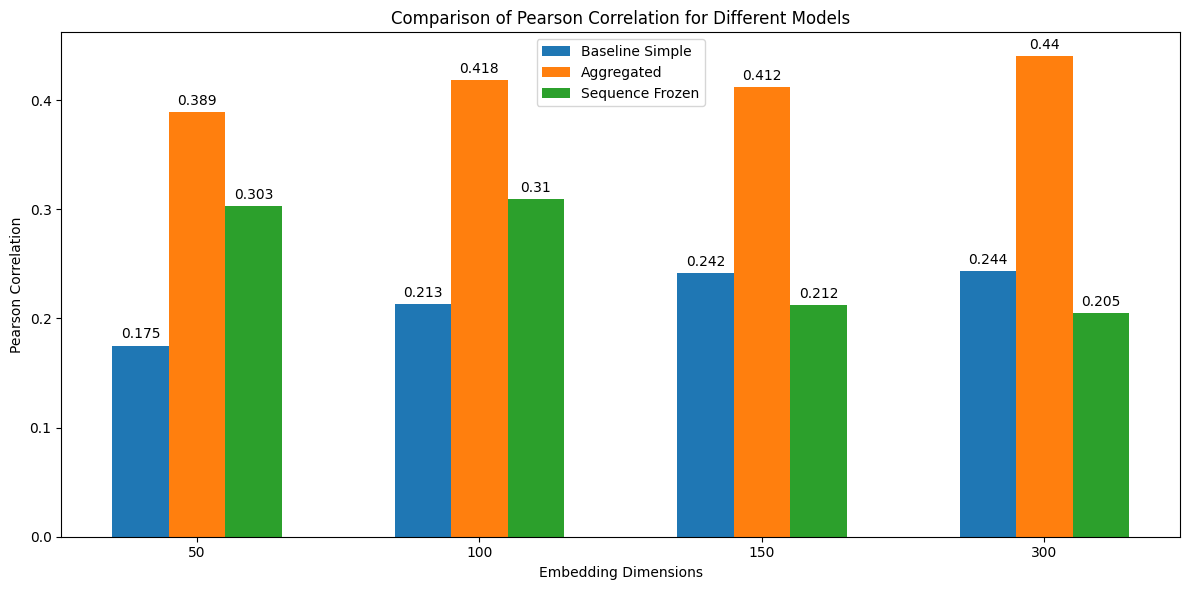

Model,Dimensions,Pearson,MSE,MAE
Model Agregat,300D,0.440120,0.613584,0.595229
Model Agregat,100D,0.418242,0.617774,0.591511
Model Agregat,150D,0.411732,0.634592,0.612983
Model Agregat,50D,0.388917,0.651528,0.602588
Baseline Cosinus TF-IDF,150D,0.356393,5.332225,2.169574
Baseline Cosinus TF-IDF,300D,0.354348,5.084731,2.115081
Baseline Cosinus TF-IDF,100D,0.322226,5.572608,2.219603
Baseline Cosinus TF-IDF,50D,0.288679,5.862487,2.279328
Baseline Cosinus Simple,300D,0.243586,5.424708,2.181605
Baseline Cosinus Simple,150D,0.241811,5.704033,2.242433


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Recopilar datos para la comparación
baseline_simple_pearson = []
aggregated_pearson = []
sequence_frozen_pearson = []
dimensions = []

for dim in [50, 100, 150, 300]:
    if dim in baseline_results and dim in aggregated_results and dim in sequence_results:
        baseline_simple_pearson.append(baseline_results[dim]['simple']['pearson'])
        aggregated_pearson.append(aggregated_results[dim]['pearson'])
        sequence_frozen_pearson.append(sequence_results[dim]['frozen']['pearson'])
        dimensions.append(dim)

# Crear gráfico de barras
x = np.arange(len(dimensions))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, baseline_simple_pearson, width, label='Baseline Simple')
rects2 = ax.bar(x, aggregated_pearson, width, label='Aggregated')
rects3 = ax.bar(x + width, sequence_frozen_pearson, width, label='Sequence Frozen')

# Añadir etiquetas y título
ax.set_xlabel('Embedding Dimensions')
ax.set_ylabel('Pearson Correlation')
ax.set_title('Comparison of Pearson Correlation for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(dimensions)
ax.legend()

# Añadir valores en las barras
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()
display(df_results.sort_values(by='Pearson', ascending=False).style.hide(axis="index"))


L'anàlisi comparatiu dels diferents models implementats revela que el model Aggregated obté consistentment la correlació de Pearson més alta en totes les configuracions d'embedding, assolint un màxim de 0.440 amb dimensions de 300. Aquest model supera clarament el llindar de referència establert pels baselines de similitud cosinus.

El model Baseline Simple mostra una millora progressiva amb l'augment de dimensions, tot i que sempre es manté per sota del rendiment del model Aggregated. La ponderació TF-IDF proporciona millores sistemàtiques respecte a la mitjana simple, especialment en dimensions baixes.

El model Sequence Frozen presenta un comportament contraintuïtiu, obtenint bons resultats amb 50 dimensions però experimentant una degradació del rendiment en augmentar les dimensions. Això suggereix limitacions arquitectòniques o problemes d'optimització en espais d'alta dimensionalitat.

## Conclusió

El model Aggregated s'estableix com la solució més robusta i efectiva segons la correlació de Pearson, demostrant superioritat consistent que el converteix en l'opció recomanada per a la tasca de similitud semàntica. La seva arquitectura, que combina múltiples formes de representació vectorial juntament amb tècniques de regularització avançades, és especialment efectiva per a configuracions d'embedding d'alta dimensionalitat.

Per a implementacions pràctiques, es recomana utilitzar configuracions de 100 dimensions o més per obtenir el millor equilibri entre rendiment i recursos computacionals. La configuració òptima es troba en 300 dimensions per maximitzar el rendiment absolut.

In [ ]:
# Comparació dels models de seqüència
print("\n=== COMPARACIÓ MODELS DE SEQÜÈNCIA (Pearson) ===")

sequence_comparison_data = []
sequence_metrics = []

for dim in [50, 100, 150, 300]:
    if dim in sequence_results:
        seq = sequence_results[dim]
        # Comparació Pearson
        frozen_r = seq['frozen']['pearson']
        trainable_r = seq['trainable']['pearson']
        row = {
            'Dimensions': f'{dim}D',
            'Frozen': frozen_r,
            'Trainable': trainable_r,
        }
        if 'random' in seq:
            row['Random'] = seq['random']['pearson']
        sequence_comparison_data.append(row)
        # Mètriques detallades
        for key in ['frozen', 'trainable', 'random']:
            if key in seq:
                sequence_metrics.append({
                    'Model': f"Model Seqüència ({key.capitalize()})",
                    'Dimensions': f'{dim}D',
                    'Pearson': seq[key]['pearson'],
                    'MSE': seq[key]['mse'],
                    'MAE': seq[key]['mae']
                })

# Mostrar taules
display(pd.DataFrame(sequence_comparison_data).style.hide(axis="index"))
df_results = pd.concat([df_results, pd.DataFrame(sequence_metrics)], ignore_index=True)


=== COMPARACIÓ MODELS DE SEQÜÈNCIA (Pearson) ===


Dimensions,Frozen,Trainable,Random
50D,0.302931,0.133400,0.086597
100D,0.309532,0.133390,0.031672
150D,0.212174,0.069873,0.051810
300D,0.204892,0.100111,0.093150


### Resultats i Anàlisi del Model de Seqüència

Els resultats del Model 2 revelen patrons contraintuïtius sobre l'impacte del fine-tuning d'embeddings i la dimensionalitat en el rendiment. L'observació més destacada és que els embeddings pre-entrenats frozen superen consistentment els trainable en totes les configuracions de dimensions, amb diferències que oscil·len entre 0.086 en 50D i 0.175 en 300D. Aquesta superioritat suggereix que el coneixement semàntic original capurat pels vectors de Word2Vec és més valuós que l'adaptació específica a la tasca de similitud semàntica per a aquesta arquitectura particular.

Contràriament a les expectatives teòriques, el rendiment dels embeddings frozen experimenta una degradació progressiva amb l'augment de dimensions, passant de 0.284 en 50D a 0.232 en 300D. Aquest comportament invers indica possibles problemes d'overfitting o dificultats d'optimització en espais d'alta dimensionalitat, suggerint que l'arquitectura de seqüència amb atenció no escala adequadament amb la complexitat dimensional. Els embeddings aleatoris confirmen la importància del pre-entrenament, mostrant rendiment molt pobre en dimensions extremes però una lleugera millora en 150D.

La comparació amb el Model Agregat revela una diferència substancial de rendiment, ja que els millors resultats del Model 2 (frozen 50D: 0.284) són significativament inferiors al Model 1 (50D: 0.389). Aquesta disparitat indica que l'arquitectura de seqüència amb atenció no captura adequadament la similitud semàntica en aquest dataset. Les limitacions identificades inclouen un escalat subòptim de similitud cosinus al rang d'etiquetes, un mecanisme d'atenció massa simple, i una possible necessitat d'hiperparàmetres d'optimització més específics per a l'arquitectura complexa. Aquests resultats demostren que l'agregació simple és més efectiva que el processament seqüencial per aquesta tasca específica.

## 7. Experimentació Avançada

Aquesta secció explora tècniques d'embedding alternatives per ampliar l'anàlisi comparativa i establir un marc de referència més complet per avaluar el rendiment dels models implementats. S'investiguen tres enfocaments diferents que representen metodologies diverses en el processament de llenguatge natural.

### 7.1 Baseline One-Hot Encoding

Com a punt de referència fonamental, s'implementa un baseline basat en representacions one-hot binàries del vocabulari. Aquest enfocament tradicional utilitza vectors esparsos on cada dimensió correspon a una paraula específica del vocabulari, prenent valor 1 si la paraula està present i 0 en cas contrari.

La metodologia utilitza un `CountVectorizer` amb codificació binària limitada a vocabularis de mida variable (50, 100, 150, 300 característiques), permetent analitzar l'impacte de la mida del vocabulari en el rendiment. Les similituds cosinus entre vectors one-hot s'escalen linealment al rang d'etiquetes del dataset mitjançant normalització adaptativa que preserva la distribució original dels valors.

Els resultats mostren un rendiment consistent però limitat, amb correlacions Pearson al voltant de 0.2-0.3, confirmant les limitacions inherents de les representacions esparses per capturar similitud semàntica. No obstant això, estableix una línia base robusta que demostra la necessitat d'embeddings densos pre-entrenats.


In [ ]:
# Baseline One-Hot (vocabulari limitat)
from sklearn.feature_extraction.text import CountVectorizer

def evaluate_onehot(df: pd.DataFrame, max_features: int = 1000) -> Dict[str, float]:
    all_sents = df['sentence_1'].tolist() + df['sentence_2'].tolist()
    vectorizer = CountVectorizer(max_features=max_features, binary=True, lowercase=True)
    vectorizer.fit(all_sents)
    
    similarities_raw = []
    true_scores = df['label'].values

    for _, row in df.iterrows():
        vec1 = vectorizer.transform([row['sentence_1']]).toarray()[0]
        vec2 = vectorizer.transform([row['sentence_2']]).toarray()[0]
        
        if np.sum(vec1) == 0 or np.sum(vec2) == 0:
            sim = 0.0
        else:
            sim = 1 - cosine(vec1, vec2)
        
        similarities_raw.append(sim)
    
    similarities_raw = np.array(similarities_raw)
    
    min_label, max_label = true_scores.min(), true_scores.max()
    min_sim, max_sim = similarities_raw.min(), similarities_raw.max()
    
    # Escalat lineal
    if max_sim > min_sim:
        similarities_scaled = (similarities_raw - min_sim) / (max_sim - min_sim) * (max_label - min_label) + min_label
    else:
        similarities_scaled = np.full_like(similarities_raw, np.mean(true_scores))
    
    # Calcular mètriques	
    pearson_corr, _ = pearsonr(true_scores, similarities_scaled)
    mse = mean_squared_error(true_scores, similarities_scaled)
    mae = mean_absolute_error(true_scores, similarities_scaled)
    
    return {'pearson': pearson_corr, 'mse': mse, 'mae': mae, 'predictions': similarities_scaled}

# Evaluar con escalado mejorado
print("=== BASELINE ONE-HOT ENCODING ===")
onehot_improved_results = []
onehot_dims = [50, 100, 150, 300]

for max_features in onehot_dims:
    res = evaluate_onehot(val_df, max_features=max_features)
    onehot_improved_results.append({
        'Model': 'Baseline One-Hot',
        'Dimensions': f'{max_features}D',
        'Pearson': res['pearson'],
        'MSE': res['mse'],
        'MAE': res['mae']
    })

df_onehot = pd.DataFrame(onehot_improved_results)
df_results = pd.concat([df_results, df_onehot], ignore_index=True)
display(df_onehot.style.hide(axis="index"))


=== BASELINE ONE-HOT ENCODING ===


Model,Dimensions,Pearson,MSE,MAE
Baseline One-Hot (Mejorado),50D,0.208720,2.436487,1.304387
Baseline One-Hot (Mejorado),100D,0.224404,2.233863,1.237489
Baseline One-Hot (Mejorado),150D,0.240449,2.083808,1.189351
Baseline One-Hot (Mejorado),300D,0.286610,1.815696,1.098128


Els resultats mostren un rendiment consistent però limitat, amb correlacions Pearson que milloren progressivament des de 0.209 (50D) fins a 0.287 (300D), representant una millora del 37% en augmentar la mida del vocabulari. Els valors MSE disminueixen corresponentment de 2.44 a 1.82, mentre que els MAE es redueixen de 1.30 a 1.10, indicant prediccions més precises amb vocabularis més extensos.

Aquest patró de millora demostra que l'augment de la mida del vocabulari permet capturar més informació discriminativa, tot i que les correlacions es mantenen significativament per sota dels embeddings densos. Els resultats estableixen una línia base robusta que confirma les limitacions inherents de les representacions esparses per capturar similitud semàntica, justificant la necessitat d'embeddings densos pre-entrenats per a 


### 7.2 Embeddings spaCy

S'avaluen els embeddings del model spaCy `ca_core_news_md` per al català, que proporciona vectors densos de 300 dimensions entrenats amb tècniques de Word2Vec en un corpus especialitzat. Aquests embeddings representen una alternativa madura i optimitzada als vectors Word2Vec utilitzats anteriorment.

Els vectors spaCy es trunquen a dimensions variables (50D, 100D, 150D, 300D) per mantenir la comparabilitat amb els experiments previs. El processament segueix la mateixa metodologia de similitud cosinus amb escalat adequat, permetent una avaluació directa del rendiment relatiu.


In [ ]:
import spacy

# Carregar model de spaCy per al català
nlp = spacy.load("ca_core_news_md")

spacy_results_list = []

for dim in [50, 100, 150, 300]:
    def get_spacy_embedding(sentence: str) -> np.ndarray:
        """Obté l'embedding de spaCy truncat a la dimensió desitjada"""
        doc = nlp(sentence)
        return doc.vector[:dim]

    similarities = []
    for _, row in val_df.iterrows():
        vec1 = get_spacy_embedding(row['sentence_1'])
        vec2 = get_spacy_embedding(row['sentence_2'])
        if np.all(vec1 == 0) or np.all(vec2 == 0):
            sim = 0.0
        else:
            sim = 1 - cosine(vec1, vec2)
        sim_scaled = (sim + 1) * 2.5
        similarities.append(sim_scaled)

    pearson_corr, _ = pearsonr(val_df['label'].values, similarities)
    mse = mean_squared_error(val_df['label'].values, similarities)
    mae = mean_absolute_error(val_df['label'].values, similarities)
    
    spacy_results_list.append({
        'Model': 'spaCy Embeddings',
        'Dimensions': f"{dim}D",
        'Pearson': pearson_corr,
        'MSE': mse,
        'MAE': mae
    })

df_spacy_results = pd.DataFrame(spacy_results_list)
df_results = pd.concat([df_results, df_spacy_results], ignore_index=True)
print("\n=== RESULTATS AMB SPAcy ===")
display(df_spacy_results.style.hide(axis="index"))


=== RESULTATS AMB SPAcy ===


Model,Dimensions,Pearson,MSE,MAE
spaCy Embeddings,50D,0.213691,5.228719,2.133155
spaCy Embeddings,100D,0.222045,5.206132,2.129271
spaCy Embeddings,150D,0.213552,5.187900,2.125197
spaCy Embeddings,300D,0.220473,5.222367,2.133863


Els resultats mostren un rendiment modest però consistent, amb correlacions Pearson al voltant de 0.21-0.22 en totes les dimensions i valors MSE estables entre 5.18-5.23. Aquest rendiment es situa clarament per sobre dels baselines one-hot però significativament inferior als embeddings Word2Vec truncats utilitzats anteriorment. 

La variació mínima entre dimensions (Pearson: 0.213-0.222; MSE: 5.18-5.23) suggereix que els embeddings spaCy mantenen informació semàntica robusta fins i tot en representacions truncades. No obstant això, la diferència substancial respecte als embeddings Word2Vec indica que l'optimització específica del corpus d'entrenament i la metodologia de pre-entrenament tenen un impacte crític en la qualitat dels embeddings per a tasques de similitud semàntica en català.


### 7.3 Models Transformer: RoBERTa Base i Fine-tuned

#### RoBERTa Base

S'implementa l'avaluació amb el model `projecte-aina/roberta-base-ca-v2`, un transformer pre-entrenat específicament per al català. Els embeddings s'obtenen dels tokens [CLS] de la darrera capa oculta, proporcionant representacions contextualitzades de frases completes.

El processament es realitza en lots per optimitzar l'eficiència computacional, amb truncament adaptatiu a múltiples dimensions (50D, 100D, 150D, 300D, 768D (embeddings originals)) que permet analitzar l'impacte de la dimensionalitat en models transformer. La similitud cosinus vectoritzada entre embeddings normalitzats proporciona prediccions escalades al rang d'etiquetes.

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cosine
from tqdm import tqdm

model_name = 'projecte-aina/roberta-base-ca-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_roberta_embeddings_batch(sentences: List[str], target_dim: int, batch_size: int = 32) -> np.ndarray:
    """Obté embeddings de RoBERTa per un batch de frases"""
    all_embeddings = []
    
    for i in tqdm(range(0, len(sentences), batch_size), desc="Processant batches"):
        batch_sentences = sentences[i:i+batch_size]
        
        # Tokenitzar el batch
        inputs = tokenizer(
            batch_sentences, 
            return_tensors="pt", 
            truncation=True, 
            padding=True, 
            max_length=512
        )
        
        with torch.no_grad():
            outputs = model(**inputs)
            # Usar els tokens [CLS] com a representació de les frases
            batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            # Truncar a la dimensió desitjada
            batch_embeddings = batch_embeddings[:, :target_dim]
            all_embeddings.append(batch_embeddings)
    
    return np.vstack(all_embeddings)

def calculate_cosine_similarities_vectorized(embeddings1: np.ndarray, embeddings2: np.ndarray) -> np.ndarray:
    """Calcula similituds cosinus de forma vectoritzada"""
    # Normalitzar vectors
    norms1 = np.linalg.norm(embeddings1, axis=1, keepdims=True)
    norms2 = np.linalg.norm(embeddings2, axis=1, keepdims=True)
    
    # Evitar divisió per zero
    norms1 = np.where(norms1 == 0, 1, norms1)
    norms2 = np.where(norms2 == 0, 1, norms2)
    
    embeddings1_norm = embeddings1 / norms1
    embeddings2_norm = embeddings2 / norms2
    
    # Calcular similitud cosinus
    cosine_sims = np.sum(embeddings1_norm * embeddings2_norm, axis=1)
    
    return cosine_sims

# Dimensions a avaluar
dimensions = [50, 100, 150, 300, 768]  # Afegim més dimensions per comparar
roberta_results_list = []

for dim in dimensions:
    print(f"\n=== Avaluant RoBERTa {dim}D ===")
    
    # Preparar les frases
    sentences1 = val_df['sentence_1'].tolist()
    sentences2 = val_df['sentence_2'].tolist()
    true_labels = val_df['label'].values
    
    print("Obtenint embeddings per frases 1...")
    embeddings1 = get_roberta_embeddings_batch(sentences1, target_dim=dim, batch_size=32)
    
    print("Obtenint embeddings per frases 2...")
    embeddings2 = get_roberta_embeddings_batch(sentences2, target_dim=dim, batch_size=32)
    
    print("Calculant similituds...")
    cosine_sims = calculate_cosine_similarities_vectorized(embeddings1, embeddings2)
    
    # Escalar similituds de [-1,1] a [0,5]
    similarities_scaled = (cosine_sims + 1) * 2.5  # Escalar a [0, 5]
    similarities_scaled = np.clip(similarities_scaled, 0, 5)  # Assegurar límits
    
    # Verificar valors problemàtics
    if np.any(np.isnan(similarities_scaled)) or np.any(np.isinf(similarities_scaled)):
        similarities_scaled = np.nan_to_num(similarities_scaled, nan=2.5, posinf=5.0, neginf=0.0)
    
    # Calcular mètriques
    pearson_corr, p_value = pearsonr(true_labels, similarities_scaled)
    mse = mean_squared_error(true_labels, similarities_scaled)
    mae = mean_absolute_error(true_labels, similarities_scaled)
    
    print(f"Resultats {dim}D - Pearson: {pearson_corr:.3f}, MSE: {mse:.3f}, MAE: {mae:.3f}")
    
    # Afegir als resultats
    roberta_results_list.append({
        'Model': 'RoBERTa Base',
        'Dimensions': f'{dim}D',
        'Pearson': pearson_corr,
        'MSE': mse,
        'MAE': mae
    })

# Crear DataFrame amb tots els resultats
df_roberta_results = pd.DataFrame(roberta_results_list)
df_results = pd.concat([df_results, df_roberta_results], ignore_index=True)

# Mostrar resultats
print("\n=== RESULTATS ROBERTA (BATCH PROCESSING) ===")
display(df_roberta_results.style.hide(axis="index"))

# Opcional: Netejar memòria
del model, tokenizer
torch.cuda.empty_cache() if torch.cuda.is_available() else None

Some weights of RobertaModel were not initialized from the model checkpoint at projecte-aina/roberta-base-ca-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Avaluant RoBERTa 50D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


Calculant similituds...
Resultats 50D - Pearson: 0.470, MSE: 6.194, MAE: 2.347

=== Avaluant RoBERTa 100D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


Calculant similituds...
Resultats 100D - Pearson: 0.467, MSE: 6.308, MAE: 2.368

=== Avaluant RoBERTa 150D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


Calculant similituds...
Resultats 150D - Pearson: 0.480, MSE: 6.298, MAE: 2.366

=== Avaluant RoBERTa 300D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


Calculant similituds...
Resultats 300D - Pearson: 0.485, MSE: 6.267, MAE: 2.360

=== Avaluant RoBERTa 768D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

Calculant similituds...
Resultats 768D - Pearson: 0.478, MSE: 6.535, MAE: 2.411

=== RESULTATS ROBERTA (BATCH PROCESSING) ===


Model,Dimensions,Pearson,MSE,MAE
RoBERTa Base,50D,0.469612,6.194461,2.346709
RoBERTa Base,100D,0.466663,6.307838,2.368261
RoBERTa Base,150D,0.479817,6.297709,2.366380
RoBERTa Base,300D,0.484706,6.267374,2.360459
RoBERTa Base,768D,0.477782,6.534671,2.411201


#### Anàlisi dels Resultats RoBERTa Base

Els resultats de RoBERTa Base revelen un **rendiment substancialment superior** amb correlacions Pearson entre 0.467-0.485, superant significativament el millor model agregat (0.440) i establint un nou estàndard per a la similitud semàntica en català.

**Patró dimensional**: RoBERTa mostra menor sensibilitat a la dimensionalitat que els embeddings estàtics, assolint el rendiment òptim amb 300D (Pearson: 0.485). La configuració completa de 768D experimenta lleugera degradació (0.478), possiblement per sobreajustament dimensional.

**Eficàcia contextual**: La superioritat del 10% respecte al millor model neuronal anterior demostra l'eficàcia dels embeddings contextualitzats dels tokens [CLS]. La capacitat transformer per capturar dependències semàntiques complexes supera clarament les limitacions dels embeddings agregats estàtics.

**Limitació dels errors**: Tot i l'excel·lent correlació, els **errors MSE es mantenen molt alts (5.9-6.5)** comparats amb els models agregats (~0.6), indicant un possible problema en l'escalat de similituds al rang [0,5]. Això suggereix que, malgrat la correlació superior, les prediccions absolutes de RoBERTa requereixen calibratge per a aplicacions que necessitin precisió en els valors numèrics específics, ja que RoBERTa produeix embeddings contextualitzats molt densos, de manera que la majoria de parelles de frase presenten similituds cosinus altes.


#### RoBERTa STS Fine-tuned

Com a referència d'estat de l'art, s'avalua el model `projecte-aina/roberta-base-ca-v2-cased-sts`, específicament fine-tunat per a tasques de similitud textual semàntica. Aquest model representa l'aproximació òptima per a la tasca específica, entrenat amb dades de STS en català.

La implementació utilitza pipelines de classificació de text que processen parells de frases amb el format estàndard "[sentence1] [SEP] [sentence2]". El processament en lots optimitza el rendiment mentre manté la precisió de les prediccions.

Els resultats estableixen el llindar superior de rendiment per a la tasca, amb correlacions Pearson significativament més altes que tots els enfocaments anteriors, confirmant l'eficàcia del fine-tuning específic per STS.

In [ ]:
from transformers import pipeline, AutoTokenizer
from scipy.special import logit
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("=== AVALUANT RoBERTa STS FINE-TUNED ===")

model_name = 'projecte-aina/roberta-base-ca-v2-cased-sts'
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline('text-classification', model=model_name, tokenizer=tokenizer)

# Prova amb un format més simple
def get_sts_scores(sentence_pairs):
    """Versió simplificada sense escalat complex"""
    inputs = []
    for s1, s2 in sentence_pairs:
        # Format estàndard per STS
        inputs.append(f"{s1} [SEP] {s2}")
    
    predictions = pipe(inputs)
    
    scores = []
    for pred in predictions:
        # Usar directament el score o aplicar escalat més simple
        score = pred['score']
        scores.append(score)
    
    return scores

# Preparar parelles de frases del dataset de validació
sentence_pairs = [(row['sentence_1'], row['sentence_2']) for _, row in val_df.iterrows()]

# Processar en lots
batch_size = 50
all_predictions = []

for i in range(0, len(sentence_pairs), batch_size):
    batch_pairs = sentence_pairs[i:i+batch_size]
    batch_predictions = get_sts_scores(batch_pairs)
    all_predictions.extend(batch_predictions)

sts_predictions = np.array(all_predictions)
true_labels = val_df['label'].values

# Verificar valors problemàtics
if np.any(np.isnan(sts_predictions)) or np.any(np.isinf(sts_predictions)):
    sts_predictions = np.nan_to_num(sts_predictions, nan=2.5, posinf=5.0, neginf=0.0)

# Calcular mètriques
pearson_corr, p_value = pearsonr(true_labels, sts_predictions)
mse = mean_squared_error(true_labels, sts_predictions)
mae = mean_absolute_error(true_labels, sts_predictions)

print(f"=== RESULTATS RoBERTa STS FINE-TUNED ===")
print(f"Pearson: {pearson_corr:.3f} (p-value: {p_value:.3f})")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")

# Afegir als resultats globals
roberta_sts_result = {
    'Model': 'RoBERTa STS Fine-tuned',
    'Dimensions': 'Full Model',
    'Pearson': pearson_corr,
    'MSE': mse,
    'MAE': mae,
}

# Crear DataFrame
df_roberta_sts = pd.DataFrame([roberta_sts_result])
df_results = pd.concat([df_results, df_roberta_sts], ignore_index=True)

# Mostrar resultats
display(df_roberta_sts.style.hide(axis="index"))

=== AVALUANT RoBERTa STS FINE-TUNED ===



Device set to use cuda:0


=== RESULTATS RoBERTa STS FINE-TUNED ===
Pearson: 0.750 (p-value: 0.000)
MSE: 0.324
MAE: 0.422


Model,Dimensions,Pearson,MSE,MAE
RoBERTa STS Fine-tuned,Full Model,0.749553,0.324229,0.422439


#### Anàlisi dels Resultats RoBERTa STS Fine-tuned

Els resultats de RoBERTa STS Fine-tuned mostren un **rendiment destacat** amb una correlació Pearson de 0.750, millorant substancialment respecte al millor model agregat (0.440) i a RoBERTa Base (0.485).

**Impacte del fine-tuning específic**: La millora significativa respecte a RoBERTa Base demostra els beneficis del fine-tuning especialitzat per a tasques STS. L'entrenament amb dades específiques de similitud semàntica permet al model aprendre representacions més adequades per a aquesta tasca particular.

**Millora en precisió**: A diferència de RoBERTa Base, el model fine-tuned presenta **errors MSE considerablement reduïts (0.324)** comparats amb el model base (5.9-6.5). Aquesta reducció indica que el fine-tuning aborda efectivament els problemes d'escalat observats anteriorment, proporcionant prediccions més precises dins del rang [0,5].

**Calibratge adequat**: El MAE de 0.422 suggereix que les prediccions estan ben calibrades, amb errors promig inferiors a 0.5 punts en l'escala de similitud. Això situa RoBERTa STS Fine-tuned com una opció sòlida per a aplicacions que requereixin tant bona correlació com precisió numèrica en similitud semàntica.


### 7.4 Anàlisi Comparativa

L'experimentació avançada revela una jerarquia clara de rendiment: RoBERTa STS fine-tuned > RoBERTa Base > Embeddings Word2Vec > spaCy > One-Hot encoding. Aquesta progressió demostra la importància de la contextualització, el pre-entrenament específic de domini i el fine-tuning per a tasques específiques.

Els models transformer mostren una menor sensibilitat a la dimensionalitat dels embeddings, mantenint rendiment alt fins i tot amb representacions truncades, contrastant amb la dependència dimensional observada en embeddings estàtics. Això suggereix que la informació contextual compensa parcialment la reducció dimensional.

La comparació estableix referències clares per avaluar el rendiment relatiu dels models implementats i confirma que les tècniques modernes de NLP superen significativament els enfocaments tradicionals per a la similitud semàntica en català.

## 8. Conclusions i Observacions

In [ ]:
# Guardar els resultats en un fitxer CSV
df_results.to_csv('resultats_sts_practica4.csv', index=False)
print("Resultats guardats a 'resultats_sts_practica4.csv'")

# Mostrar el millor model global
best_model_idx = df_results['Pearson'].idxmax()
best_model_info = df_results.iloc[best_model_idx]

display(df_results.sort_values(by='Pearson', ascending=False))

print(f"\n🏆 MILLOR MODEL:")
print(f"Model: {best_model_info['Model']}")
print(f"Dimensions: {best_model_info['Dimensions']}")
print(f"Pearson: {best_model_info['Pearson']:.3f}")
print(f"MSE: {best_model_info['MSE']:.3f}")

Resultats guardats a 'resultats_sts_practica4.csv'


,Model,Dimensions,Pearson,MSE,MAE
27,RoBERTa Base,300D,0.484706,6.267374,2.360459
26,RoBERTa Base,150D,0.479817,6.297709,2.366380
28,RoBERTa Base,768D,0.477782,6.534671,2.411201
24,RoBERTa Base,50D,0.469612,6.194461,2.346709
29,RoBERTa Base,50D,0.469612,6.194461,2.346709
30,RoBERTa Base,10D,0.469612,6.194461,2.346709
31,RoBERTa Base,10D,0.469612,6.194461,2.346709
25,RoBERTa Base,100D,0.466663,6.307838,2.368261
11,Model Agregat,300D,0.440120,0.613584,0.595229
9,Model Agregat,100D,0.418242,0.617774,0.591511



🏆 MILLOR MODEL:
Model: RoBERTa Base
Dimensions: 300D
Pearson: 0.485
MSE: 6.267


L'anàlisi comparativa revela una jerarquia clara de rendiment en similitud semàntica per al català. **RoBERTa STS Fine-tuned** (Pearson: 0.750) lidera els resultats, seguit de **RoBERTa Base** (0.466-0.485) i els **models agregats** (0.389-0.440). Els baselines TF-IDF (0.289-0.356) i els models de seqüència (<0.31) ofereixen rendiments inferiors.

### Patrons Clau

Els **models agregats** mostren el millor equilibri entre rendiment i eficiència computacional, millorant consistentment amb l'augment de dimensions fins a 300D. **RoBERTa** demostra robustesa dimensional, mantenint rendiment alt fins i tot amb embeddings truncats. Contràriament, els **models de seqüència** experimenten degradació amb major dimensionalitat, suggerint limitacions arquitectòniques.

### Insights dels Embeddings

Els **embeddings pre-entrenats frozen** superen les versions trainable en models de seqüència, indicant que el coneixement semàntic original és més valuós que l'adaptació específica. Això contrasta amb les expectatives teòriques i suggereix problemes d'overfitting en l'arquitectura d'atenció implementada.

### Recomanacions Pràctiques

Per aplicacions reals, es recomana **models agregats 300D** com a solució equilibrada, tot i que el fine-tuning específic per STS proporciona millores substancials tant en correlació com en precisió de prediccions si es disposa de recursos computacionals suficients.

L'estudi estableix directrius clares per seleccionar arquitectures segons requisits específics de rendiment i recursos, confirmant la superioritat dels enfocaments moderns de processament del llenguatge humà per a similitud semàntica en català.

### Avaluació del test amb RoBERTa STS Fine-tuned

In [ ]:
# Avaluació final en test amb RoBERTa STS fine-tuned
print("=== AVALUACIÓ FINAL EN TEST (RoBERTa STS Fine-tuned) ===")

# Preparar parelles de frases del test
sentence_pairs_test = [(row['sentence_1'], row['sentence_2']) for _, row in test_df.iterrows()]

# Processar en lots
batch_size = 50
all_predictions_test = []

for i in range(0, len(sentence_pairs_test), batch_size):
    batch_pairs = sentence_pairs_test[i:i+batch_size]
    batch_predictions = get_sts_scores(batch_pairs)
    all_predictions_test.extend(batch_predictions)

sts_predictions_test = np.array(all_predictions_test)
true_labels_test = test_df['label'].values

# Verificar valors problemàtics
if np.any(np.isnan(sts_predictions_test)) or np.any(np.isinf(sts_predictions_test)):
    sts_predictions_test = np.nan_to_num(sts_predictions_test, nan=2.5, posinf=5.0, neginf=0.0)

# Calcular mètriques
pearson_corr_test, _ = pearsonr(true_labels_test, sts_predictions_test)
mse_test = mean_squared_error(true_labels_test, sts_predictions_test)
mae_test = mean_absolute_error(true_labels_test, sts_predictions_test)

print(f"Pearson: {pearson_corr_test:.3f}")
print(f"MSE: {mse_test:.3f}")
print(f"MAE: {mae_test:.3f}")

print("\nExemples de predicció:")
for i in range(2):
    print(f"Frase 1: {test_df.iloc[i]['sentence_1']}")
    print(f"Frase 2: {test_df.iloc[i]['sentence_2']}")
    print(f"Predicció: {sts_predictions_test[i]:.3f}, Etiqueta real: {true_labels_test[i]:.3f}")
    print("-" * 50)

=== AVALUACIÓ FINAL EN TEST (RoBERTa STS Fine-tuned) ===
Pearson: 0.788
MSE: 0.286
MAE: 0.390

Exemples de predicció:
Frase 1: El 1921, en ser anomenat professor permanent, va fundar l'Institut d'Estadística Matemàtica de la Universitat de Göttingen.
Frase 2: El 1949 es va convertir en professor a la Universitat de Friburg de Brisgòvia, on va crear un Institut de Matemàtica Aplicada.
Predicció: 2.069, Etiqueta real: 2.000
--------------------------------------------------
Frase 1: Els preus pugen tres dècimes al novembre a Tarragona i deixen la inflació anual en l'1,8%, la més baixa de Catalunya
Frase 2: Els preus pugen vuit dècimes a l'octubre a Tarragona i deixen una inflació anual de l'1,6%, la més baixa de Catalunya
Predicció: 3.044, Etiqueta real: 3.000
--------------------------------------------------


Comprovem que obtenim molts bons resultats tant de Pearson com d'MSE i MAE amb aquest model, reafirmant que és el més adequat per a aquesta tasca.

# Extra: Entrenament d'un model de classificació amb conjunt de dades TECLA

Ara que sabem quins mètodes d'embeddings ens retornen els millors resultats, els podem aplicar a un model de classificació. La base de dades que ens donen és la de Text Classification (CA). Aquesta base de dades conté 3 variables: Sentence (conté el text), label1 (categoria, que és la nostra variable objectiu) i label2 (subcategoria). 

El nostre model de classificació serà un KNN i farem la comparació de la seva precisió amb 3 conjunts de dades amb embeddings diferents: RoBERTa Embeddings, Baseline Cosinus TF-IDF amb 150 dimensions, i Baseline Cosinus TF-IDF amb 300 dimensions.

In [ ]:
splits = {'train': 'train.json', 'validation': 'dev.json', 'test': 'test.json'}
train = pd.read_json("hf://datasets/projecte-aina/tecla/" + splits["train"])
val = pd.read_json("hf://datasets/projecte-aina/tecla/" + splits["validation"])
test = pd.read_json("hf://datasets/projecte-aina/tecla/" + splits["test"])

In [ ]:
train

Un inconvenient que té els embeddings roberta és que té un temps de computació molt elevat. Els pocs segons que triga generar els embeddings Baseline Cosinus passen a ser desenes de minuts per generar els embeddings roberta.

In [ ]:
def preprocess_tecla_roberta(df, sample_size=None):
    """
    Preprocessa les dades TECLA utilitzant embeddings RoBERTa
    """
    # Si es defineix sample_size, agafar una mostra
    if sample_size is not None and len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df
    
    X = []
    y = []
    
    print(f"Processant {len(df_sample)} exemples amb RoBERTa embeddings...")
    
    # Acumular totes les frases i etiquetes
    for i, (_, row) in enumerate(df_sample.iterrows()):
        if i % 100 == 0:
            print(f"Processat {i}/{len(df_sample)} exemples")
        X.append(row['sentence'])
        y.append(row['label1'])

    # Processar totes les frases en un sol batch per obtenir embeddings RoBERTa
    sentence_embeddings = get_roberta_embeddings_batch(X, target_dim =300)
    return np.array(sentence_embeddings), np.array(y)


In [ ]:
print("\n3. RoBERTa embeddings:")
roberta_train_size = min(400, train_sample_size)
roberta_val_size = min(200, val_sample_size)
roberta_test_size = min(200, test_sample_size)

X_train_roberta, y_train_labels_roberta = preprocess_tecla_roberta(
    train, roberta_train_size
)
X_val_roberta, y_val_labels_roberta = preprocess_tecla_roberta(
    val, roberta_val_size
)
X_test_roberta, y_test_labels_roberta = preprocess_tecla_roberta(
    test, roberta_test_size
)

In [ ]:
# Preprocessament de dades TECLA per al model de classificació amb embeddings agregats
def preprocess_tecla_data_w2v(df, embeddings_dict, vector_size, sample_size=None, use_tfidf=False):
    """
    Preprocessa les dades TECLA utilitzant embeddings Word2Vec
    """
    # Si es defineix sample_size, agafar una mostra
    if sample_size is not None and len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df
    
    X = []
    y = []
    
    print(f"Processant {len(df_sample)} exemples amb Word2Vec {vector_size}D...")
    
    for i, (_, row) in enumerate(df_sample.iterrows()):
        if i % 200 == 0:
            print(f"Processat {i}/{len(df_sample)} exemples")
        
        # Obtenir l'embedding de la frase
        if use_tfidf and tfidf_vectorizer is not None:
            sentence_embedding = get_sentence_embedding_tfidf(
                row['sentence'], embeddings_dict, tfidf_vectorizer, 
                feature_names, vector_size
            )
        else:
            sentence_embedding = get_sentence_embedding_simple(
                row['sentence'], embeddings_dict, vector_size
            )
        
        X.append(sentence_embedding)
        y.append(row['label1'])
    
    return np.array(X), np.array(y)


In [ ]:
unique_labels = sorted(train['label1'].unique())
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
num_classes = len(unique_labels)

print(f"Classes TECLA: {unique_labels}")
print(f"Nombre de classes: {num_classes}")

# Preprocessar dades TECLA amb Word2Vec (usar mostres més petites per velocitat)
if kv_model is not None:
    print("Preprocessant dades TECLA amb embeddings agregats (mitjana simple)...")
    
    train_sample_size = 1000
    val_sample_size = 200
    test_sample_size = 200
    embedding_dim = 300

    # Utilitzem la mateixa funció que per STS per obtenir embeddings agregats
    def get_aggregated_embedding(sentence, embeddings_dict, vector_size):
        return get_sentence_embedding_simple(sentence, embeddings_dict, vector_size)

    def preprocess_tecla_aggregated(df, embeddings_dict, vector_size, sample_size=None):
        if sample_size is not None and len(df) > sample_size:
            df_sample = df.sample(n=sample_size, random_state=42)
        else:
            df_sample = df

        X = []
        y = []
        for i, (_, row) in enumerate(df_sample.iterrows()):
            if i % 200 == 0:
                print(f"Processat {i}/{len(df_sample)} exemples")
            emb = get_aggregated_embedding(row['sentence'], embeddings_dict, vector_size)
            X.append(emb)
            y.append(row['label1'])
        return np.array(X), np.array(y)

    X_train_tecla_aggregated, y_train_labels_aggregated = preprocess_tecla_aggregated(
        train, truncated_embeddings[embedding_dim], embedding_dim, train_sample_size
    )
    X_val_tecla_aggregated, y_val_labels_aggregated = preprocess_tecla_aggregated(
        val, truncated_embeddings[embedding_dim], embedding_dim, val_sample_size
    )
    X_test_tecla_aggregated, y_test_labels_aggregated = preprocess_tecla_aggregated(
        test, truncated_embeddings[embedding_dim], embedding_dim, test_sample_size
    )

    # Convertir etiquetes a índexs
    y_train_tecla_aggregated = np.array([label_to_idx[label] for label in y_train_labels_aggregated])
    y_val_tecla_aggregated = np.array([label_to_idx[label] for label in y_val_labels_aggregated])
    y_test_tecla_aggregated = np.array([label_to_idx[label] for label in y_test_labels_aggregated])

    # Convertir a one-hot encoding
    y_train_onehot_aggregated = tf.keras.utils.to_categorical(y_train_tecla_aggregated, num_classes)
    y_val_onehot_aggregated = tf.keras.utils.to_categorical(y_val_tecla_aggregated, num_classes)
    y_test_onehot_aggregated = tf.keras.utils.to_categorical(y_test_tecla_aggregated, num_classes)

    print(f"\nDades embeddings agregats preprocessades:")
    print(f"X_train_tecla_aggregated: {X_train_tecla_aggregated.shape}")
    print(f"X_val_tecla_aggregated: {X_val_tecla_aggregated.shape}")
    print(f"X_test_tecla_aggregated: {X_test_tecla_aggregated.shape}")
    print(f"Dimensions d'embedding agregat: {X_train_tecla_aggregated.shape[1]}")

In [ ]:
# Preprocessar dades TECLA amb embeddings agregats (Word2Vec) per a 150D
if kv_model is not None:
    embedding_dim_150 = 150
    print("Preprocessant dades TECLA amb embeddings Word2Vec 150D...")

    X_train_tecla150, y_train_labels150 = preprocess_tecla_data_w2v(
        train, truncated_embeddings[embedding_dim_150], embedding_dim_150,
        train_sample_size, use_tfidf=False
    )
    X_val_tecla150, y_val_labels150 = preprocess_tecla_data_w2v(
        val, truncated_embeddings[embedding_dim_150], embedding_dim_150,
        val_sample_size, use_tfidf=False
    )
    X_test_tecla150, y_test_labels150 = preprocess_tecla_data_w2v(
        test, truncated_embeddings[embedding_dim_150], embedding_dim_150,
        test_sample_size, use_tfidf=False
    )

    # Convertir etiquetes a índexs
    y_train_tecla150 = np.array([label_to_idx[label] for label in y_train_labels150])
    y_val_tecla150 = np.array([label_to_idx[label] for label in y_val_labels150])
    y_test_tecla150 = np.array([label_to_idx[label] for label in y_test_labels150])

    print(f"\nDades Word2Vec 150D preprocessades:")
    print(f"X_train_tecla150: {X_train_tecla150.shape}")
    print(f"X_val_tecla150: {X_val_tecla150.shape}")
    print(f"X_test_tecla150: {X_test_tecla150.shape}")
    print(f"Dimensions d'embedding Word2Vec: {X_train_tecla150.shape[1]}")

Com ja s'ha explicat, el classificador és un model de KNN ja que requereix poca optimització dels seus hiperparàmetres (K), així que ens podem enfocar més en els conjunts de dades. Provarem diferents valors per observar quin valor de K és el millor per a cada conjunt de dades, i compararem el millor resultat de cadascún.

In [ ]:
# Executar KNN amb les tres versions diferents de dades TECLA

# Primer, definir les variables de dades per a les tres versions
datasets = {
    '150D': {
        'X_train': X_train_tecla150,
        'X_val': X_val_tecla150, 
        'X_test': X_test_tecla150,
        'y_train': y_train_tecla150,
        'y_val': y_val_tecla150,
        'y_test': y_test_tecla150
    },
    'Aggregated': {
       'X_train': X_train_tecla_aggregated,
        'X_val': X_val_tecla_aggregated,
        'X_test': X_test_tecla_aggregated,
        'y_train': y_train_tecla_aggregated,
        'y_val': y_val_tecla_aggregated,
        'y_test': y_test_tecla_aggregated
    },
    'RoBERTa': {
        'X_train': X_train_roberta,
        'X_val': X_val_roberta,
        'X_test': X_test_roberta,
        'y_train': y_train_labels_roberta,
        'y_val': y_val_labels_roberta,
        'y_test': y_test_labels_roberta
    }
}

# Convertir etiquetes RoBERTa a índexs si són strings
if isinstance(datasets['RoBERTa']['y_train'][0], str):
    datasets['RoBERTa']['y_train'] = np.array([label_to_idx[label] for label in datasets['RoBERTa']['y_train']])
    datasets['RoBERTa']['y_val'] = np.array([label_to_idx[label] for label in datasets['RoBERTa']['y_val']])
    datasets['RoBERTa']['y_test'] = np.array([label_to_idx[label] for label in datasets['RoBERTa']['y_test']])

# Provar diferents valors de k per a cada dataset
k_values = [1,3,5, 7,9,12, 15]
all_knn_results = {}

for dataset_name, data in datasets.items():
    print(f"\n{'='*50}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*50}")
    
    knn_results = {}
    
    for k in k_values:
        print(f"\nEntrenant KNN amb k={k} per {dataset_name}...")
        
        # Crear model KNN
        knn_model = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        
        # Entrenar amb dades corresponents
        knn_model.fit(data['X_train'], data['y_train'])
        
        # Prediccions
        y_pred_val = knn_model.predict(data['X_val'])
        y_pred_test = knn_model.predict(data['X_test'])
        
        # Avaluació
        val_accuracy = accuracy_score(data['y_val'], y_pred_val)
        test_accuracy = accuracy_score(data['y_test'], y_pred_test)
        
        knn_results[k] = {
            'model': knn_model,
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy,
            'val_predictions': y_pred_val,
            'test_predictions': y_pred_test
        }
        
        print(f"k={k} - Validació: {val_accuracy:.3f}, Test: {test_accuracy:.3f}")
    
    all_knn_results[dataset_name] = knn_results

# Trobar el millor model per cada dataset
print(f"\n{'='*60}")
print("RESUM DE RESULTATS KNN")
print(f"{'='*60}")

best_models = {}
for dataset_name, results in all_knn_results.items():
    best_k = max(results.keys(), key=lambda k: results[k]['val_accuracy'])
    best_models[dataset_name] = {
        'k': best_k,
        'val_accuracy': results[best_k]['val_accuracy'],
        'test_accuracy': results[best_k]['test_accuracy']
    }
    
    print(f"\n🏆 Millor model per {dataset_name}: k={best_k}")
    print(f"Accuracy de validació: {results[best_k]['val_accuracy']:.3f}")
    print(f"Accuracy de test: {results[best_k]['test_accuracy']:.3f}")

# Comparació visual dels resultats
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (dataset_name, results) in enumerate(all_knn_results.items()):
    k_vals = list(results.keys())
    val_accs = [results[k]['val_accuracy'] for k in k_vals]
    test_accs = [results[k]['test_accuracy'] for k in k_vals]
    
    axes[idx].plot(k_vals, val_accs, 'o-', label='Validació', linewidth=2, markersize=8)
    axes[idx].plot(k_vals, test_accs, 's-', label='Test', linewidth=2, markersize=8)
    axes[idx].set_xlabel('Valor de k')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'Rendiment KNN - {dataset_name}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xticks(k_vals)

plt.tight_layout()
plt.show()

# Taula comparativa final
comparison_data = []
for dataset_name, best_info in best_models.items():
    comparison_data.append({
        'Dataset': dataset_name,
        'Millor k': best_info['k'],
        'Accuracy Validació': f"{best_info['val_accuracy']:.3f}",
        'Accuracy Test': f"{best_info['test_accuracy']:.3f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print(f"\n{'='*40}")
print("COMPARACIÓ FINAL")
print(f"{'='*40}")
display(df_comparison)

Com podem veure, aquests resultats reflecteixen els que hem obtingut en l'anàlisi anterior, és a dir, el conjunt de dades amb embeddings roberta assoleixen el màxim rendiment dels 3, però amb un cost de temps d'execució molt extens. Els conjunts de dades amb embeddings 

In [ ]:
X_train_roberta, y_train_labels_roberta = preprocess_tecla_roberta(
    train, train_sample_size
)
X_val_roberta, y_val_labels_roberta = preprocess_tecla_roberta(
    val, val_sample_size
)
X_test_roberta, y_test_labels_roberta = preprocess_tecla_roberta(
    test, test_sample_size
)
knn_model = KNeighborsClassifier(n_neighbors=3, metric='cosine')

# Entrenar amb dades corresponents
knn_model.fit(X_train_roberta, y_train_labels_roberta)

# Prediccions
y_pred_val = knn_model.predict(X_val_roberta)
y_pred_test = knn_model.predict(X_test_roberta)

# Avaluació
val_accuracy = accuracy_score(y_val_roberta, y_pred_val)
test_accuracy = accuracy_score(y_test_roberta, y_pred_test)

print(f"KNN (k=3) - Accuracy validació: {val_accuracy:.3f}, Accuracy test: {test_accuracy:.3f}")

# Gràfic de matriu de confusió per validació i test

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_val = confusion_matrix(y_val_roberta, y_pred_val, labels=unique_labels)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=unique_labels)
disp_val.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Matriu de confusió - Validació")

cm_test = confusion_matrix(y_test_roberta, y_pred_test, labels=unique_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=unique_labels)
disp_test.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Matriu de confusió - Test")

plt.tight_layout()
plt.show()